## Load data

In [128]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

random_state = 42

In [129]:
from ucimlrepo import fetch_ucirepo 
  
census_income = fetch_ucirepo(id=20) 
df = census_income.data['original']

df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)
df['income'] = df['income'].apply(lambda x: 1 if x.startswith('>50K') else 0)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

# Replace '?' with NaN, if necessary (check those special characters)
df_train.replace("?", np.nan, inplace=True)
df_test.replace("?", np.nan, inplace=True)

ratio_features = ["age", "capital-gain", "capital-loss", "hours-per-week"]
ordinal_features = [
    "education-num"
]  # 'education-num' is a numerical representation of 'education' ('education' will be removed)
nominal_features = [
    "workclass",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
]  # 'native-country' will be removed
target = "income"

df_train.drop_duplicates(inplace=True, ignore_index=True)
df_test.drop_duplicates(inplace=True, ignore_index=True)

columns_to_drop = ["native-country", "fnlwgt", "education"]
df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)
df_train.shape

(39041, 12)

## Clean data

In [130]:
def clean_data(X):
    X = X.reset_index(drop=True)
    X = X.drop(columns=["fnlwgt", "education"], errors="ignore")
    cols = list(X.columns)
    X[cols] = X[cols].replace([" ?"], np.nan)
    X = X.dropna()

    def strip_str(x):
        if isinstance(x, str):
            return x.strip()
        else:
            return x

    X = X.applymap(strip_str)
    X["relationship"] = X["relationship"].replace(["Husband", "Wife"], "Married")
    X["hours-per-week"] = pd.cut(
        x=X["hours-per-week"],
        bins=[0.9, 25, 39, 40, 55, 100],
        labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"],
    )
    X.age = pd.qcut(X.age, q=7)
    # X['artificial_feature'] = pd.qcut(X['artificial_feature'], q=5)
    X["capital-gain"] = pd.cut(
        X["capital-gain"],
        bins=[-1, 1, 1000, 5000, 10000, 100000, 1000000],
        labels=["None", "Low", "Medium", "High", "VeryHigh", "Rich"],
    )
    X["capital-loss"] = pd.cut(
        X["capital-loss"],
        bins=[-1, 1, 1000, 5000, 10000, 100000, 1000000],
        labels=["None", "Low", "Medium", "High", "VeryHigh", "Rich"],
    )
    return X

In [131]:
df_train_ = df_train.copy()
df_test_ = df_test.copy()
df_train_cleaned = clean_data(df_train_)
df_test_cleaned = clean_data(df_test_)

/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_16490/1617873902.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(strip_str)
/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_16490/1617873902.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(strip_str)


## Train baseline

In [132]:
def describe_model(y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred, average='macro')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='macro')}")
    print(f"F1: {f1_score(y_test, y_pred, average='macro')}")

In [133]:
def split_data(df, target, drop_na=False):
    _df = df.copy()
    if drop_na:
        _df = _df.dropna()
    
    X = _df.drop(columns=[target])
    y = _df[target]

    return X, y

def train_and_evaluate(model, df_train, df_test, target, drop_na = False, sample_weight = None):
    X_train, y_train = split_data(df_train, target, drop_na)
    X_test, y_test = split_data(df_test, target, drop_na)

    if sample_weight is not None:
        model.fit(X_train, y_train, logisticregression__sample_weight=sample_weight)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return y_test, y_pred

In [134]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

categorical_features_onehot_transformer = ColumnTransformer(
    transformers=[
        ("one-hot-encoder", OneHotEncoder(handle_unknown="ignore"), nominal_features),
    ],
    remainder="passthrough",
)

model = Pipeline(
    [
        ("one-hot-encoder", categorical_features_onehot_transformer),
        ("clf", LogisticRegression(max_iter=1000, random_state=random_state)),
    ]
)

In [135]:
y_test, y_pred = train_and_evaluate(model, df_train_, df_test_, target, drop_na=True)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [136]:
describe_model(y_test, y_pred)

Accuracy: 0.8476439220807487
Precision: 0.809112688862722
Recall: 0.7633409111426626
F1: 0.7815289731647761


## Fairness Evaluation

In [137]:
features_4_scanning = nominal_features + ordinal_features + ratio_features

In [138]:
def print_report(data, subset):
    """Utility function to pretty-print the subsets."""
    if subset:
        to_choose = data[subset.keys()].isin(subset).all(axis=1)
        df = data[["income", "income-predicted"]][to_choose]
    else:
        for col in features_4_scanning:
            subset[col] = list(data[col].unique())
        df = data[["income", "income-predicted"]]

    true = df["income"].sum()
    pred = df["income-predicted"].sum()

    print("\033[1mSubset: \033[0m")
    print(subset)
    print("\033[1mSubset Size: \033[0m", len(df))
    print("\033[1mTrue Clicks: \033[0m", true)
    print("\033[1mPredicted Clicks: \033[0m", pred)
    print()

In [139]:
from aif360.detectors.mdss.ScoringFunctions import Bernoulli
from aif360.detectors.mdss.MDSS import MDSS

to_delete = df_train_.copy()
to_delete.dropna(inplace=True)

to_delete = clean_data(to_delete)
_, y_pred = train_and_evaluate(model, df_train_, df_train_, target, drop_na=True)
to_delete["income-predicted"] = y_pred

# Bias scan
scoring_function = Bernoulli(direction="negative")
scanner = MDSS(scoring_function)

scanned_subset, _ = scanner.scan(
    to_delete[features_4_scanning],
    expectations=to_delete["income-predicted"],
    outcomes=to_delete["income"],
    penalty=50,
    num_iters=5,
    verbose=False,
)

print_report(to_delete, scanned_subset)

/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_16490/1617873902.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(strip_str)
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

Subset: 
{'occupation': ['Exec-managerial', 'Prof-specialty'], 'relationship': ['Married']}
Subset Size:  5431
True Clicks:  3776
Predicted Clicks:  4580



/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated a

In [140]:
import fairlens as fl

fscorer = fl.FairnessScorer(
    df_train_,
    target_attr="income",
    sensitive_attrs=scanned_subset.keys(),
)

fscorer.demographic_report()

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/fairlens/utils.py:223: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col_date = pd.to_datetime(column, errors="coerce")
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/fairlens/utils.py:223: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col_date = pd.to_datetime(column, errors="coerce")


Sensitive Attributes: ['occupation', 'relationship']

                   Group Distance  Proportion  Counts   P-Value
Exec-managerial, Husband    0.447    0.066469    2595  0.00e+00
               Own-child   -0.224    0.156630    6115  0.00e+00
 Prof-specialty, Husband    0.466    0.055455    2165  0.00e+00
                 Husband    0.211    0.403243   15743 4.94e-324
           Not-in-family   -0.141    0.257370   10048 1.22e-291
         Exec-managerial    0.239    0.124305    4853 5.41e-287
           Other-service   -0.196    0.100202    3912 3.39e-250
          Prof-specialty    0.208    0.127558    4980 5.36e-225
               Unmarried   -0.180    0.103942    4058 8.42e-209
          Sales, Husband    0.289    0.046336    1809 1.96e-154

Weighted Mean Statistical Distance: 0.17676951290306936


In [107]:
from aif360.sklearn.detectors.facts import FACTS

X_train, y_train = split_data(df_train_, target, drop_na=True)
X_test, y_test = split_data(df_test_, target, drop_na=True)

# load FACTS framework with:
# - the model to be audited
# - protected attribute "sex" and
# - assigning equal, unit weights to all features for cost computation.
# - no features forbidden from changing, i.e. user can specify any features that cannot change at all.
detector = FACTS(
    clf=model,
    prot_attr=scanned_subset.keys(),
    feature_weights={f: 1 for f in X_train.columns},
    feats_not_allowed_to_change=[],
)

In [108]:
X_test.dropna(inplace=True)

In [ ]:
detector = detector.fit(X_train)

In [ ]:
# Detects the top `top_count` most biased groups based on the given metric
# available metrics are:
# - equal-effectiveness
# - equal-choice-for-recourse
# - equal-effectiveness-within-budget
# - equal-cost-of-effectiveness
# - equal-mean-recourse
# - fair-tradeoff
# a short description for each metric is given below
detector.bias_scan(metric="equal-choice-for-recourse", phi=0.1, top_count=3)

In [ ]:
# prints the result into a nicely formatted report
detector.print_recourse_report(
    show_action_costs=False,
    show_subgroup_costs=True,
    show_unbiased_subgroups=False,
)

If hours-per-week = FullTime, relationship = Not-in-family:
	Protected Subgroup '(0.418, 1.161]', 12.73% covered
		Make hours-per-week = BrainDrain, relationship = Married with effectiveness 8.74%.
		Make hours-per-week = OverTime, relationship = Married with effectiveness 4.37%.
		Make relationship = Married with effectiveness 1.94%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup '(-2.387, 0.418]', 11.90% covered
		Make hours-per-week = BrainDrain, relationship = Married with effectiveness 4.19%.
		Make hours-per-week = OverTime, relationship = Married with effectiveness 2.09%.
		Make relationship = Married with effectiveness 0.52%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup '(1.161, 2.053]', 13.53% covered
		Make hours-per-week = BrainDrain, relationship = Married with effectiveness 4.57%.
		Make hours-per-week = OverTime, relationship = Married with effectiveness 3.20%.
		Make relationship = Married with effectiveness 1.37%.
		Aggregate co

### Next evaluator

In [114]:
from sklearn.pipeline import Pipeline

categorical_features_onehot_transformer2 = ColumnTransformer(
    transformers=[
        (
            "one-hot-encoder",
            OneHotEncoder(handle_unknown="ignore"),
            df_train_cleaned.select_dtypes(include=["object", "category"]).columns.to_list(),
        ),
    ],
    remainder="passthrough",
)

model2 = Pipeline(
    [
        ("one-hot-encoder", categorical_features_onehot_transformer2),
        ("clf", MLPClassifier(verbose=False, max_iter=25, random_state=random_state)),
    ]
)

In [142]:
X_train, y_train = split_data(df_train_, target, drop_na=True)
model2.fit(X_train, y_train)
probs = pd.Series(model.predict_proba(X_train)[:, 1])

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [256]:
from aif360.detectors.mdss_detector import bias_scan

privileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="Bernoulli",
    expectations=probs,
    overpredicted=True,
    penalty=50,
    alpha=0.24,
    favorable_value=1,
)

unprivileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="Bernoulli",
    expectations=probs,
    overpredicted=False,
    penalty=50,
    alpha=0.24,
    favorable_value=1
)

In [257]:
print(privileged_subset)
print(unprivileged_subset)

({'capital-gain': [5013]}, 97.9166)
({'capital-loss': [1887]}, 15.142)


In [258]:
def extract_protected_attributes(result):
    attr, val = [], []

    for (attribute, value) in result:
        attr.append(attribute)
        val.append(value)

    return attr, val

### Ignore

In [259]:
dff = X_train.copy()
dff["observed"] = y_train
dff["probabilities"] = probs.copy()

In [260]:
dff

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-loss,hours-per-week,capital-gain,observed,probabilities
capital-gain,,,,,,,,,,,,,
0,32,Private,9,Married-civ-spouse,Transport-moving,Husband,White,1,0,40,0,0,0.181946
0,45,State-gov,14,Married-civ-spouse,Prof-specialty,Husband,White,1,0,40,0,1,0.181946
0,35,Local-gov,8,Married-civ-spouse,Farming-fishing,Husband,White,1,0,40,0,0,0.181946
0,64,Private,9,Divorced,Craft-repair,Unmarried,White,1,0,20,0,0,0.181946
0,63,Self-emp-not-inc,9,Widowed,Sales,Not-in-family,White,1,0,70,0,0,0.181946
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,35,Private,13,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,1,1887,50,0,1,0.181946
0,21,Private,9,Never-married,Machine-op-inspct,Own-child,White,0,0,40,0,0,0.181946
0,23,Private,9,Divorced,Adm-clerical,Not-in-family,White,0,0,40,0,0,0.181946


In [261]:
to_choose = dff[privileged_subset[0].keys()].isin(privileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected privileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
    len(temp_df),
    np.round(temp_df["observed"].mean(), 4),
    np.round(temp_df["probabilities"].mean(), 4),
)

'Our detected privileged group has a size of 103, we observe 0.0 as the average probability of earning >50k, but our model predicts 0.6717'

In [262]:
to_choose = dff[unprivileged_subset[0].keys()].isin(unprivileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected unprivileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
    len(temp_df),
    np.round(temp_df["observed"].mean(), 4),
    np.round(temp_df["probabilities"].mean(), 4),
)

'Our detected unprivileged group has a size of 185, we observe 1.0 as the average probability of earning >50k, but our model predicts 0.1819'

In [263]:
from aif360.sklearn.detectors import bias_scan
from aif360.sklearn.metrics import mdss_bias_score

priv_sub, priv_score = bias_scan(
    X_train, y_train, probs, pos_label=1, penalty=0.5, overpredicted=True
)
priv = df_train_[priv_sub.keys()].isin(priv_sub).all(axis=1)
priv_sub, priv_score

({'capital-gain': [594,
   914,
   1086,
   1151,
   1173,
   1409,
   1424,
   1455,
   1471,
   1506,
   1797,
   1848,
   2009,
   2050,
   2105,
   2174,
   2202,
   2228,
   2290,
   2329,
   2346,
   2354,
   2407,
   2414,
   2463,
   2580,
   2597,
   2635,
   2653,
   2829,
   2885,
   2907,
   2936,
   2961,
   2964,
   3137,
   3273,
   3325,
   3411,
   3432,
   3456,
   3464,
   3471,
   3674,
   3781,
   3818,
   3887,
   3908,
   3942,
   4064,
   4101,
   4416,
   4508,
   4650,
   4865,
   4931,
   5013,
   5455,
   5721,
   6360,
   6497,
   6723,
   6767,
   6849,
   7443,
   7978,
   10566,
   34095,
   41310]},
 599.0114)

In [264]:
print(f"Observed: {dff[priv].observed.mean():.2%}")
print(f"Expected: {dff[priv].probabilities.mean():.2%}")
print(f"n = {sum(priv)}")

priv_unpen = mdss_bias_score(
    y_train, probs, X=X_train, subset=priv_sub, pos_label=1, overpredicted=True, penalty=0
)
print(f"unpenalized score: {priv_unpen:.2f}")

Observed: nan%
Expected: nan%
n = 1160
unpenalized score: 633.51


/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_16490/3085341137.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Observed: {dff[priv].observed.mean():.2%}")
/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_16490/3085341137.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Expected: {dff[priv].probabilities.mean():.2%}")


In [265]:
unpriv_sub, unpriv_score = bias_scan(
    X_train, y_train, probs, pos_label=1, penalty=0.5, overpredicted=False
)
unpriv = df_train_[unpriv_sub.keys()].isin(unpriv_sub).all(axis=1)
unpriv_sub, unpriv_score

({'capital-gain': [3103,
   4687,
   4787,
   4934,
   5178,
   6097,
   6418,
   6514,
   7262,
   7298,
   7430,
   7688,
   8614,
   9386,
   9562,
   10520,
   10605,
   11678,
   13550,
   14084,
   14344,
   15024]},
 274.6469)

In [266]:
print(f"Observed: {dff[unpriv].observed.mean():.2%}")
print(f"Expected: {dff[unpriv].probabilities.mean():.2%}")
print(f"n = {sum(unpriv)}")

unpriv_unpen = mdss_bias_score(
    y_train, probs, X=X_train, subset=unpriv_sub, pos_label=1, overpredicted=False, penalty=0
)
print(f"unpenalized score: {unpriv_unpen:.2f}")

Observed: nan%
Expected: nan%
n = 1605
unpenalized score: 285.65


/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_16490/2666253846.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Observed: {dff[unpriv].observed.mean():.2%}")
/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_16490/2666253846.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Expected: {dff[unpriv].probabilities.mean():.2%}")


### Fairness Metrics

In [313]:
from aif360.sklearn.metrics import (
    equal_opportunity_difference,
    average_odds_difference,
    statistical_parity_difference,
    disparate_impact_ratio,
    theil_index,
)

def create_dataset(df, protected_attributes, priveleged_groups) -> pd.DataFrame:
    column_renaming = {}
    for i, col in enumerate(protected_attributes):
        df[f"{col}_index"] = df[col].copy()
        df[f"{col}"] = df[col].map(lambda x: 1 if x in priveleged_groups[i] else 0)
        column_renaming[f"{col}_index"] = f"{col}"

    if len(protected_attributes) > 0:
        df.set_index(protected_attributes, inplace=True)
        df = df.rename(columns=column_renaming)

    return df


def calculate_fairness_metrics(
    observed, predictions, protected_attributes, priveleged_group
):
    fairness_metrics = {}

    fairness_metrics["statistical_parity_difference"] = statistical_parity_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["average_odds_difference"] = average_odds_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["disparate_impact"] = disparate_impact_ratio(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["theil_index"] = theil_index(1 + predictions - observed)

    return fairness_metrics

In [277]:
df_train_bias = df_train_.copy()
df_test_bias = df_test_.copy()
df_train_bias.dropna(inplace=True)
df_test_bias.dropna(inplace=True)
df_train_bias = create_dataset(
    df_train_bias, list(privileged_subset[0].keys()), list(privileged_subset[0].values())
)
#df_test_bias = create_dataset(
#    df_test_bias, list(privileged_subset[0].keys()), list(privileged_subset[0].values())
#)
df_train_bias.head(5)

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-loss,hours-per-week,income,capital-gain
capital-gain,,,,,,,,,,,,
0,32,Private,9,Married-civ-spouse,Transport-moving,Husband,White,1,0,40,0,0
0,45,State-gov,14,Married-civ-spouse,Prof-specialty,Husband,White,1,0,40,1,0
0,35,Local-gov,8,Married-civ-spouse,Farming-fishing,Husband,White,1,0,40,0,0
0,64,Private,9,Divorced,Craft-repair,Unmarried,White,1,0,20,0,0
0,63,Self-emp-not-inc,9,Widowed,Sales,Not-in-family,White,1,0,70,0,0


In [314]:
train = df_train_bias.copy()
train.dropna(inplace=True)
X_train, y_train = train.drop(columns=[target], axis=1), train[target]
model = model.fit(X_train, y_train)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [315]:
test = df_test_.copy()
X_test, y_test = test.drop(columns=[target]), test[target]
y_pred = model.predict(X_test)

print(f"Accuracy = {(y_test.values == y_pred).sum() / y_test.shape[0]:.2%}")

Accuracy = 84.87%


In [316]:
y_pred = model.predict(X_train)
metrics = calculate_fairness_metrics(
    df_train_bias[target], y_pred, list(privileged_subset[0].keys()), (1)
)
metrics

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'statistical_parity_difference': -0.6356979079411588,
 'average_odds_difference': -0.08511804029193604,
 'equal_opportunity_difference': 0.5969298245614035,
 'disparate_impact': 0.23864087769837958,
 'theil_index': 0.12512870035352922}

In [317]:
from aif360.detectors.mdss_detector import bias_scan

def iterate_it(df, model, penalty):
    _df = df.copy()
    X_train, y_train = split_data(_df, target, drop_na=True)
    model.fit(X_train, y_train)
    y_probs = pd.Series(model.predict_proba(X_train)[:, 1])

    privileged_subset = bias_scan(
        data=X_train,
        observations=y_train,
        scoring="Bernoulli",
        expectations=y_probs,
        overpredicted=True,
        penalty=penalty,
        alpha=0.24,
        favorable_value=1,
    )

    df_bias = df.copy()
    df_bias.dropna(inplace=True)

    df_bias = create_dataset(
        df_bias, list(privileged_subset[0].keys()), list(privileged_subset[0].values())
    )

    X_train, y_train = df_bias.drop(columns=[target], axis=1), df_bias[target]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)

    if len(privileged_subset[0].keys()) == 0:
        return {
            "statistical_parity_difference": 0,
             "average_abs_odds_difference": 0,
            "equal_opportunity_difference":0,
            "disparate_impact": 0,
            "theil_index": 0,
        }, privileged_subset
    else:
        metrics = calculate_fairness_metrics(
            df_bias[target], y_pred, list(privileged_subset[0].keys()), (1,) * len(privileged_subset[0].keys())
        )
        return metrics, privileged_subset

In [318]:
df_bias = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)

for i in [1, 5, 25, 50, 100]:
    metrics, priv = iterate_it(df_train_, model, i)    
    df_bias.loc[f"penalty_{i}"] = metrics.values()

display(df_bias)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

,statistical_parity_difference,average_abs_odds_difference,equal_opportunity_difference,disparate_impact,theil_index
penalty_1,-0.139074,0.160666,0.59693,0.586526,0.125129
penalty_5,-0.224306,0.118608,0.59693,0.467091,0.125129
penalty_25,-0.547976,-0.041824,0.59693,0.265068,0.125129
penalty_50,-0.635698,-0.085118,0.59693,0.238641,0.125129
penalty_100,-0.635698,-0.085118,0.59693,0.238641,0.125129


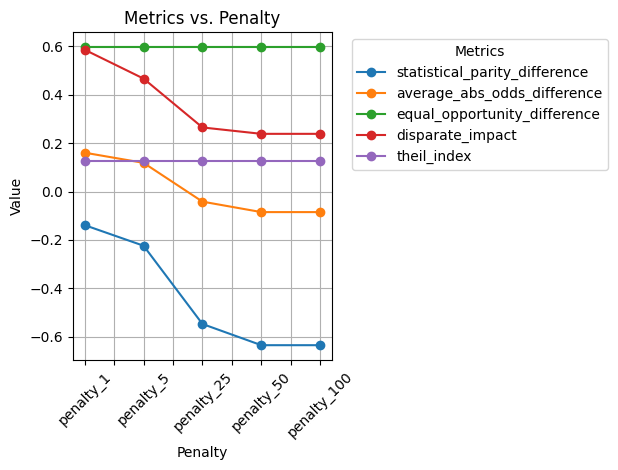

In [319]:
df_bias.plot(kind="line", marker='o')
plt.xlabel("Penalty")
plt.ylabel("Value")
plt.title("Metrics vs. Penalty")
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()